# Driver Distraction Detection Project
## Using Deep Learning and Raspberry Pi
(This project is part of the internship program in Wadi Makkah - ML track)

### Team members:
- Hanan Alharbi
- Ahmad Alkaf
- Neaam Hariri

### Team Mentor: 
- Sarah Khyyat

## Description:
Driver Distraction Detection system uses deep learning to detect and classify driver behaviours while driving the car. The system will be embedded in a raspberry pi camera that can detect those behaviours. The camera then monitors the driver and when it detects a behaviour that should not be done during driving, the system will alarm the user.

## Step 1: Import Dependencies

In [1]:
#import dependencies
from collections import OrderedDict
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt                        
%matplotlib inline 

## Step 2: Import Datasets

In [2]:
data_dir = r'C:\Users\han-1\Desktop\WadiMakkah\Images'

In [3]:
IMG_SIZE = 112

Defining transformations and augementations of data:

In [4]:
#data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}


Defining and loading the three datasets: training, validation, and testing:

In [5]:
train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(data_dir + '/test', transform=data_transforms['test'])

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [8]:
classes = train_dataset.classes

In [9]:
print(classes)
print(len(classes))

['c0', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
9


## Step 3: Train and Validate Using Transfer Learning (VGG16 - Resenet - DenseNet)

In [10]:
use_cuda = torch.cuda.is_available()

In [11]:
print(use_cuda)

True


In [12]:
print(torch.cuda.current_device())

0


In [13]:
def chooseModel(model):
  
    if model == 'vgg':
        #Load vgg-16 pre-trained model
        model_transfer_vgg16 = models.vgg16(pretrained=True)
        save_transfer_vgg16 = 'transfer_vgg16.pt'
        IMG_SIZE = 224
        return model_transfer_vgg16, save_transfer_vgg16
  
    elif model == 'resnet':
        #Load Resenet-50 pre-trained model
        model_transfer_resnet50 = models.resnet50(pretrained=True)
        save_transfer_resnet50 = 'transfer_resent50.pt'
        IMG_SIZE = 229 #224
        print('resnet')
        # in - 2048
        return model_transfer_resnet50, save_transfer_resnet50
  
    elif model == 'densenet':
        #Load DenseNet-161 pre-trained model
        model_transfer_densenet = models.densenet161(pretrained=True)
        save_transfer_densenet = 'transfer_densenet.pt'
        IMG_SIZE = 224 #
        print('densenet')
        # in - 2208
        return model_transfer_densenet, save_transfer_densenet
  
    else:
        return print('The model you chose does not exist')

Fine-tuning the last layers (classifier) of the pre-trained model and defining the model archeticture:

In [14]:
#fine-tune model
def fineTuneModel(model, in_features, out_features, dropout, h):
  
    model_transfer = model
  
    # freeze the model parameters
    for param in model_transfer.parameters():
        param.require_grad = False

    # define the classifier layers
    classifier = nn.Sequential(OrderedDict([
        ('dropout1', nn.Dropout(dropout)),
        ('fc1', nn.Linear(in_features, h)),
        ('relu1', nn.ReLU()),
        ('dropout2', nn.Dropout(dropout)),
        ('fc2', nn.Linear(h, out_features)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
  
    # update the model classifier
    model_transfer.classifier = classifier
    
    if use_cuda:
        model_transfer = model_transfer.cuda()
    
    return model_transfer

Define the loss and optimizer of the model:

In [15]:
# loss and optimizer
def lossAndOptimizer(opt, model, lr=0.05):
    
    criterion = nn.CrossEntropyLoss()
    
    if opt == 'adam':
        optimizer = optim.Adam(model.classifier.parameters(), lr)
    elif opt == 'SGD':
        optimizer = optim.SGD(model.classifier.parameters(), lr)
    elif opt == 'rms':
        optimizer = optim.RMSprop(model.classifier.parameters(), lr)
        
    return criterion, optimizer

Defining the training and validation process:

In [16]:
# load the truncated images to prevent the error OSError: image file is truncated
#ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # train the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
          
          
        # validate the model 
        model.eval()
        #with torch.no_grad():
            
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()

                #torch.backends.cuda.cufft_plan_cache.clear()
            # update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
             
    return model

Defining the testing process:

In [17]:
def test(loaders, model, criterion, use_cuda):
  
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
                                                          
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
                                                          
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

Defining the prediction process:

In [50]:
#define predict function
def predict(model, img_path, m_classes):
    
    
    
    img = Image.open(img_path)
    
    img_transform = transforms.Compose([transforms.Resize(128),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])])
    
    img = img_transform(img).unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
    
    prediction = model(img)
    index = torch.max(prediction, 1)[1].item()
    
    case = ''
    for i in range(len(m_classes)):
        if index == i:
            case = m_classes[i]
            break
        
    return case

## Step 4: Try Different Models and Choose the Best

### Step 4.1: VGG-16

In [20]:
model_vgg16, save_path_vgg16 = chooseModel('vgg')

In [21]:
model_vgg16 = fineTuneModel(model_vgg16, 25088, 9, 0.2, 1000)

In [22]:
criterion, optimizer = lossAndOptimizer('SGD', model_vgg16, 0.01)

In [23]:
model_vgg16 = train(50, loaders, model_vgg16, optimizer, criterion, use_cuda, save_path_vgg16)

Epoch: 1 	Training Loss: 1.977255 	Validation Loss: 1.497615
Validation loss decreased (inf --> 1.497615).  Saving model ...
Epoch: 2 	Training Loss: 1.692879 	Validation Loss: 1.316374
Validation loss decreased (1.497615 --> 1.316374).  Saving model ...
Epoch: 3 	Training Loss: 1.527323 	Validation Loss: 1.243338
Validation loss decreased (1.316374 --> 1.243338).  Saving model ...
Epoch: 4 	Training Loss: 1.460693 	Validation Loss: 0.849185
Validation loss decreased (1.243338 --> 0.849185).  Saving model ...
Epoch: 5 	Training Loss: 1.397266 	Validation Loss: 1.282168
Epoch: 6 	Training Loss: 1.346164 	Validation Loss: 0.925430
Epoch: 7 	Training Loss: 1.302955 	Validation Loss: 0.689093
Validation loss decreased (0.849185 --> 0.689093).  Saving model ...
Epoch: 8 	Training Loss: 1.249296 	Validation Loss: 0.789670
Epoch: 9 	Training Loss: 1.239781 	Validation Loss: 1.559652
Epoch: 10 	Training Loss: 1.209618 	Validation Loss: 0.691414
Epoch: 11 	Training Loss: 1.166021 	Validation Lo

In [ ]:
model_vgg16.load_state_dict(torch.load(save_path_vgg16))

In [25]:
test(loaders, model_vgg16, criterion, use_cuda)

Test Loss: 0.284322
Test Accuracy: 90% (1618/1783)


In [23]:
model_vgg16 = train(50, loaders, model_vgg16, optimizer, criterion, use_cuda, 'second_data_vgg16.pt')

Epoch: 1 	Training Loss: 2.134855 	Validation Loss: 1.821914
Validation loss decreased (inf --> 1.821914).  Saving model ...
Epoch: 2 	Training Loss: 1.966500 	Validation Loss: 1.872328
Epoch: 3 	Training Loss: 1.905541 	Validation Loss: 1.553319
Validation loss decreased (1.821914 --> 1.553319).  Saving model ...
Epoch: 4 	Training Loss: 1.847722 	Validation Loss: 1.509960
Validation loss decreased (1.553319 --> 1.509960).  Saving model ...
Epoch: 5 	Training Loss: 1.805662 	Validation Loss: 1.452709
Validation loss decreased (1.509960 --> 1.452709).  Saving model ...
Epoch: 6 	Training Loss: 1.771387 	Validation Loss: 1.471060
Epoch: 7 	Training Loss: 1.749658 	Validation Loss: 1.374866
Validation loss decreased (1.452709 --> 1.374866).  Saving model ...
Epoch: 8 	Training Loss: 1.718929 	Validation Loss: 1.420907
Epoch: 9 	Training Loss: 1.675201 	Validation Loss: 1.235857
Validation loss decreased (1.374866 --> 1.235857).  Saving model ...
Epoch: 10 	Training Loss: 1.639168 	Valida

In [24]:
model_vgg16.load_state_dict(torch.load('second_data_vgg16.pt'))

In [25]:
test(loaders, model_vgg16, criterion, use_cuda)

Test Loss: 0.822751
Test Accuracy: 72% (2288/3143)


In [ ]:
###load the two saved model and test on the same images###

In [26]:
# model_1 was trained on state farm data - accuracy 90%
model_1 = models.vgg16(pretrained=True)
model_1 = fineTuneModel(model_1, 25088, 9, 0.2, 1000)
model_1.load_state_dict(torch.load('transfer_vgg16.pt'))

In [27]:
# model_2 was trained on the data requested from Yehya Abouelnaga, AUC Distracted Driver Dataset - accuracy 72%
model_2 = models.vgg16(pretrained=True)
model_2 = fineTuneModel(model_2, 25088, 9, 0.2, 1000)
model_2.load_state_dict(torch.load('second_data_vgg16.pt'))

In [43]:
def img_show(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

In [51]:
classes_1 = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8']
classes_2 = ['c0', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

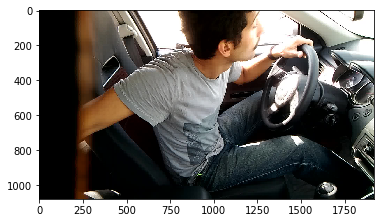

c6
c4


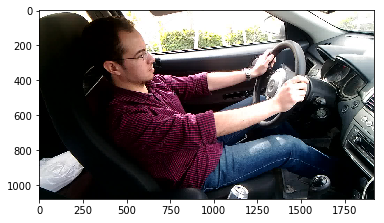

c8
c7


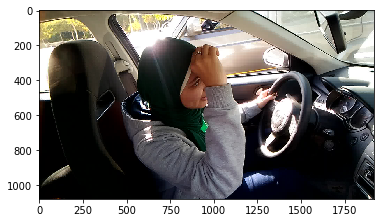

c7
c3


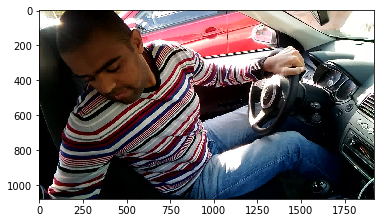

c6
c6


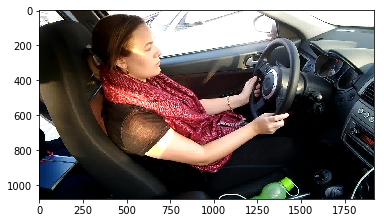

c8
c8


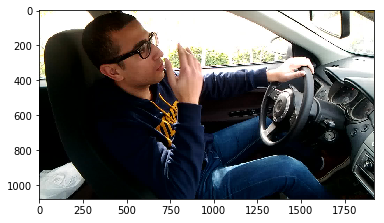

c7
c3


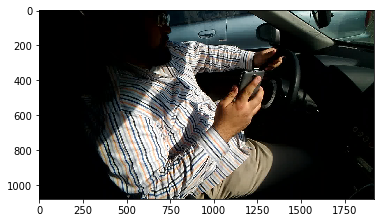

c6
c6


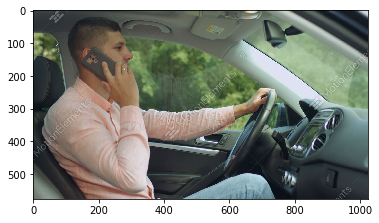

c7
c7


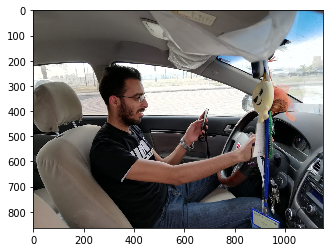

c7
c7


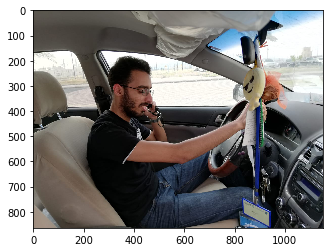

c8
c7


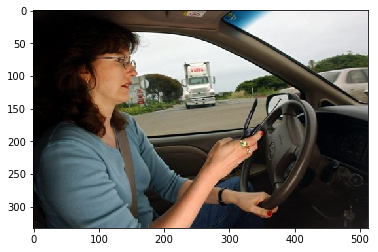

c8
c9


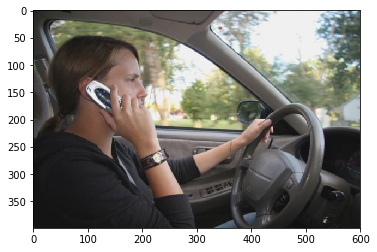

c2
c7


In [59]:
imgs = os.listdir(r'C:\Users\han-1\Desktop\WadiMakkah\imgs')
path = r'C:\Users\han-1\Desktop\WadiMakkah\imgs\\'
for img in imgs:
    img_show(path + img)
    p1 = predict(model_1, path + img, classes_1)
    p2 = predict(model_2, path + img, classes_2)
    print(p1)
    print(p2)

### Step 4.2: ResNet-50

In [ ]:
model_resnet50, save_path_resnet50 = chooseModel('resnet')

In [ ]:
model_resnet50 = fineTuneModel(model_resnet50, 2048, 10, 0.2)

In [ ]:
criterion, optimizer = lossAndOptimizer('adam', model_resnet50, 0.01)

In [ ]:
model_resnet50 = train(3, loaders, model_resnet50, optimizer, criterion, use_cuda, save_path_resnet50)

In [ ]:
model_resnet50.load_state_dict(torch.load(save_path_resnet50))

In [ ]:
test(loaders, model_resnet50, criterion, use_cuda)

### Step 4.3: DenseNet-161

In [ ]:
model_densenet161, save_path_densenet161 = chooseModel('densenet')

In [ ]:
model_densenet161 = fineTuneModel(model_densenet161, 2208, 9, 0.2)

In [ ]:
criterion, optimizer = lossAndOptimizer('adam', model_densenet161, 0.01)

In [ ]:
model_densenet161 = train(50, loaders, model_densenet161, optimizer, criterion, use_cuda, save_path_densenet161)

In [ ]:
model_densenet161.load_state_dict(torch.load(save_path_densenet161))

In [ ]:
test(loaders, model_densenet161, criterion, use_cuda)